In [1]:
import random
from intervaltree import IntervalTree, Interval
from typing import Optional
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from copy import deepcopy
import numpy as np
import pandas as pd

In [2]:
random.seed(42)
N = 8
hours_active = 24
route_len = 90
change_time = 15
pop_size = 50
hours_daily = 8
hours_shift = 12
peak_amount = 5
nonpeak_amount=3
race_per_week_min, race_per_week_max = 10,200
def amount_at_hour(time):
    time%=24*60
    if time < 8*60 or time > 21*60:
        return 1
    if 7*60<=time<9*60 or 18*60<=time<20*60:
        return peak_amount
    else:
        return nonpeak_amount
    
def amount_at_hour(time): # переопределена: 1 ночью, 5 днём, 3 в выходные
    day_time=time%24*60
    if day_time < 8*60 or day_time > 20*60:
        return 1
    elif time>=24*60*5:
        return nonpeak_amount
    else:
        return peak_amount

In [3]:
def intervals_for_daily(time_begin):
    n = int(hours_daily//(route_len/60))
    r_len= route_len
    time = time_begin+r_len
    intervals = [(time_begin,time-1)]
    fl=True
    for i in range(n-1):
        if 13<=(time/60)%24<=15 and fl:
            fl=False
            time+=60
        intervals.append((time,time+r_len-1))
        time+=r_len
    if fl:
        print("ERROR: COULD NOT FIND A BREAK TIME FOR TIME:", time_begin)
    return intervals

def intervals_for_shift(time_begin):
    n = int(hours_shift//(route_len/60))
    r_len= route_len
    time = time_begin+r_len
    intervals = [(time_begin,time-1)]
    fl=False
    for i in range(n-1):
        if fl:
            fl=False
            time+=2
        else:
            fl=True
        intervals.append((time,time+r_len-1))
        time+=r_len
    return intervals

In [4]:
class Driver():
    def __init__(self, dr_type:int, dr_id:int):
        self.dr_type = dr_type # 1 дневной 0 сменный
        self.id=dr_id
        self.last_driven = []
        routes_per_day = hours_daily if dr_type else hours_shift
        self.routes_per_day = int(routes_per_day//(route_len/60))
        self.total_time = 102*5 if dr_type else 150*5
        self.dr_schedule = []

    def check_avaible(self, time):
        if len(self.last_driven)==0:
                return True
        if self.dr_type==0:
            if self.last_driven[-1] + 2*24*60 <= time: # 2 дня перерыва
                return True
            else: return False
        # if time>1440:
        #     return False
        if len(self.last_driven)==0:
            return True
        if self.last_driven[-1]//1440 < time//1440:
            return True
        return False

class Bus_schedule():
    _id = 0
    def __init__(self):
        self.schedule = IntervalTree()
        self.id = Bus_schedule._id
        Bus_schedule._id+=1

    def interval_checker(self, begin, driver: Driver):
        inter_arr:list[tuple[int,int]]=[]
        if driver.dr_type:
            inter_arr = intervals_for_daily(begin)
        else:
            inter_arr = intervals_for_shift(begin)
        for begin, end in inter_arr:
            if begin>(7*24*60):
                self.schedule.addi(begin%(7*24*60),end%(7*24*60),f"{driver.id}.{driver.dr_type}")
            elif end>(7*24*60):
                self.schedule.addi(begin,end,f"{driver.id}.{driver.dr_type}")
                self.schedule.addi(0,end%(7*24*60),f"{driver.id}.{driver.dr_type}")
            else:
                self.schedule.addi(begin,end,f"{driver.id}.{driver.dr_type}")


class Schedule():
    _id_counter = 0
    def __init__(self,buses: Optional[list[Bus_schedule]] = None, shift_chance: Optional[float]=None):
        self.buses:list[Bus_schedule] = []
        if buses is None:
            self.buses = [Bus_schedule() for i in range(N)]
        else:
            self.buses = buses
        self.score = 1
        self.drivers = 1000
        self.estimated1 = False
        self.estimated2 = False
        self.id = Schedule._id_counter
        Schedule._id_counter+=1
        self.marked_buses: list[Bus_schedule] = [Bus_schedule() for i in range(N)]
        self.dr_prev_week = 0
        self.driver_list: list[Driver] = []
        self.shift_chance=random.uniform(0.2, 0.8) if shift_chance is None else shift_chance
        # self.counter_daily_id = -1
        # self.counter_shift_id = -1

    def __eq__(self, other: 'Schedule'):
        if not isinstance(other, Schedule):
            return NotImplemented
        return self.id == other.id
    
    def __ne__(self, other):
        return not self.__eq__(other)

    def estimate1(self):
        if self.estimated1:
            return
        self.score = 100000*5
        self.estimated1=True
        test=0
        for i in self.buses:
            test+=len(i.schedule)
        all_buses = IntervalTree()
        for bus in self.buses:
            all_buses |= bus.schedule
        if test!=len(all_buses):
            print("something wrong")
            print("test =",test,"union =",len(all_buses))
        for i in range(10080):
            amount_now = len(all_buses[i])
            amount_best = amount_at_hour(i)
            if amount_now==0:
                self.score-=100
            # elif amount_now < amount_best:
            #     self.score-=10*(amount_best-amount_now)
            # elif amount_now>amount_best:
            #     self.score-=5*(amount_now-amount_best)
            else:
                self.score-=5*(amount_best-amount_now)**2
        # print(self.score, end=" ")
    
    def estimate2(self):
        if self.estimated2:
            return
        if not self.estimated1:
            self.estimate1()
        self.estimated2=True
        self.drivers=0
        self.marked_buses = [Bus_schedule() for i in range(len(self.buses))]
        self.driver_list=[]
        r_len= route_len
        for i in range(10080):
            for j in range(len(self.buses)):
                t = list(self.buses[j].schedule.envelop(i,i+r_len-1))
                if len(t)==0: continue
                if (t[0].end - t[0].begin) != r_len - 1:
                    continue
                dr_t, beg, bus_id = list(t)[0].data.split(".")
                dr_t=int(dr_t)
                beg=int(beg)
                if not beg: continue
                new = False
                if len(self.driver_list)>0:
                    for dr in self.driver_list:
                        if dr.dr_type==dr_t and dr.check_avaible(i):
                            self.marked_buses[j].interval_checker(i, dr)
                            dr.last_driven.append(i+dr.total_time-1)
                            dr.dr_schedule.append((i,i+dr.total_time-1))
                            break
                    else: 
                        new = True
                else:
                    new = True
                if new:
                    dr = Driver(dr_type=dr_t,dr_id=self.drivers+1)
                    self.drivers+=1
                    self.driver_list.append(dr)
                    self.marked_buses[j].interval_checker(i, dr)
                    dr.last_driven.append(i+dr.total_time-1)
                    dr.dr_schedule.append((i,i+dr.total_time-1))

In [5]:
def check_bus(bus: Bus_schedule, time_begin, time_end):
    if len(bus.schedule[time_begin - change_time:time_end+change_time-1])==0:
        if time_end+change_time-1>7*24*60 and len(bus.schedule[0:(time_end+change_time-1)%(7*24*60)])>0:
            return False
        return True
    return False


def gen_bus(bus:Bus_schedule, shift_chance=0.333):
    dr_type = 1 if random.random()>shift_chance else 0
    if dr_type: # дневной
        day = random.randint(0,4)
        begin = day*1440 + random.randint(7*60, 12*60) # от 7:00 до 12:00
        total_time = 510
        if check_bus(bus, begin, begin+total_time):
            inter = intervals_for_daily(begin)
        else:
            for _ in range(2):
                day = random.randint(0,4)
                begin = day*1440 + random.randint(7*60, 12*60)
                if check_bus(bus, begin, begin+total_time):
                    inter = intervals_for_daily(begin)
                    break
            else: return
    else: # сменный
        begin = random.randint(0,10080-1)
        total_time = 750
        if check_bus(bus, begin, begin+total_time):
            inter = intervals_for_shift(begin)
        else:
            for _ in range(2):
                begin = random.randint(0,10080-1)
                if check_bus(bus, begin, begin+total_time):
                    inter = intervals_for_shift(begin)
                    break
            else: return
    fl = 1
    for i in inter:
        if i[0]>(7*24*60):
            bus.schedule[i[0]%(7*24*60):i[1]%(7*24*60)]=f"{dr_type}.{fl}.{bus.id}"
        elif i[1]>(7*24*60):
            bus.schedule[i[0]:i[1]]=f"{dr_type}.{fl}.{bus.id}"
            bus.schedule[0:i[1]%(7*24*60)]=f"{dr_type}.{fl}.{bus.id}"
        else:
            bus.schedule[i[0]:i[1]]=f"{dr_type}.{fl}.{bus.id}"
        if fl:
            fl=0

def gen_pop(population:list[Schedule], shift_chance=0.333):
    for sched in population:
        races = random.randint(race_per_week_min,race_per_week_max)
        for _ in range(races):
            bus = sched.buses[random.randint(0, len(sched.buses)-1)]
            gen_bus(bus, sched.shift_chance)
            
                    

In [6]:
def crossover(sch1: Schedule, sch2:Schedule):
    child1,child2 = Schedule(deepcopy(sch1.buses)),Schedule(deepcopy(sch2.buses))
    for i in range(N):
        if random.getrandbits(1):
            child1.buses[i], child2.buses[i] = deepcopy(child2.buses[i]), deepcopy(child1.buses[i]) # random swap
    return child1, child2

def mutation(sch: Schedule):
    mutated_sch = Schedule(sch.buses, sch.shift_chance)
    id = random.randint(0, len(mutated_sch.buses)-1)
    mutated_sch.buses[id] = Bus_schedule()
    gen_bus(mutated_sch.buses[id], mutated_sch.shift_chance)
    return mutated_sch   

def selection(old_pop:list[Schedule], best_schedule_per_iter:list[Schedule]):
    pop_size = len(old_pop)
    for sch in old_pop:
        sch.estimate1()
        print(sch.score,end=" ")
    print()
    old_pop = [sch for sch in old_pop if sch.score >= 0]
    old_pop.sort(key=lambda x: x.score,reverse=True)
    temp_pop = old_pop[:min(pop_size//2,len(old_pop))]
    best_sch = temp_pop[:min(pop_size//10,len(temp_pop))] # 10%
    for i in best_sch:
        i.estimate2()
    best_sch.sort(key=lambda x: x.drivers)
    best_sch = best_sch[:min(pop_size//20,len(best_sch))] # 5%
    if len(best_sch)>0:
        best_schedule_per_iter.append(best_sch[0])
    else:
        print("no best on this iter!")
    if len(temp_pop)*2<pop_size:
        while len(temp_pop)*2<pop_size:
            t = Schedule()
            races = random.randint(race_per_week_min,race_per_week_max)
            for _ in range(races):
                bus = t.buses[random.randint(0, len(t.buses)-1)]
                gen_bus(bus, t.shift_chance)
            temp_pop.append(t)
    new_pop = deepcopy(best_sch)
    for parent1 in best_sch:
        parent2 = random.choice(old_pop)
        while parent2 == parent1:
            parent2 = random.choice(old_pop)
        child1, child2 = crossover(parent1, parent2)
        new_pop.extend([child1, child2])
    while len(new_pop)<0.85*pop_size:
        parent1 = random.choice(old_pop)
        parent2 = random.choice(old_pop)
        while parent2 == parent1:
            parent2 = random.choice(old_pop)
        child1, child2 = crossover(parent1, parent2)
        new_pop.extend([child1, child2])
    while len(new_pop)<pop_size:
            t = Schedule()
            races = random.randint(race_per_week_min,race_per_week_max)
            for _ in range(races):
                bus = t.buses[random.randint(0, len(t.buses)-1)]
                gen_bus(bus,t.shift_chance)
            new_pop.append(t)
    return new_pop[:pop_size]


def evolution(population:list[Schedule], gen_limit:int=100_000, mutate_chance:float=0.05):
    best_schedule_per_iter:list[Schedule]=[Schedule()]
    last_change=0
    last_score = 0
    last_drivers=9999
    for i in range(gen_limit):
        if i%1==0 and i>0: print("Current generation:", i,"best_res_score:",best_schedule_per_iter[-1].score, "best_res_drivers:",best_schedule_per_iter[-1].drivers)
        population = selection(population, best_schedule_per_iter)
        population=[i if random.random()>mutate_chance else mutation(i) for i in population]
        if best_schedule_per_iter[-1].score>last_score or (best_schedule_per_iter[-1].score==last_score and best_schedule_per_iter[-1].drivers<last_drivers):
            last_score=best_schedule_per_iter[-1].score
            last_drivers = best_schedule_per_iter[-1].drivers
            last_change = i
        if last_change+50<=i: # 50 итераций без изменений - break
            break
    return best_schedule_per_iter

In [7]:
population = [Schedule() for i in range(pop_size)]
gen_pop(population)
print("starting evolution...")
best_schedules = evolution(population)

starting evolution...
150510 -288720 59515 88765 -67955 112790 210785 80200 112375 15315 -131555 216705 -76575 23660 57255 136150 11055 94125 102285 10150 192525 113715 -93260 123970 65075 102240 55105 80310 143380 149125 175395 137895 44310 163185 137870 11875 60015 75115 218935 -227715 138550 -47670 107130 145165 115025 89790 -136460 128615 125130 101095 
Current generation: 1 best_res_score: 218935 best_res_drivers: 15
218935 216705 152830 136870 142500 231345 113580 50385 50885 108640 62665 155685 153220 164055 113715 107130 148525 192525 210785 113715 179615 129825 98650 59030 229155 238710 201870 195795 550 14550 104375 34700 109930 118590 150725 127455 74095 21935 150140 176020 232215 199340 109475 88585 147395 182720 127245 99125 21250 33495 
Current generation: 2 best_res_score: 218935 best_res_drivers: 15
218935 232215 194790 231940 227675 -3955 93620 77495 123065 165620 126250 182340 94690 130525 65975 125865 170330 203645 86015 186930 70195 107000 194215 133710 162700 18698

In [9]:
def display_multiple_interval_trees_and_get_drivers(trees):
    day_labels=['ПН','ВТ','СР','ЧТ','ПТ','СБ','ВС']
    minutes_in_day = 288*5
    hours_in_day = 24
    x = np.arange(0, 2016*5)
    tick_positions_days = np.arange(0, len(x), minutes_in_day)
    tick_positions_hours = np.arange(0, len(x), minutes_in_day // hours_in_day)
    trees = trees.marked_buses
    fig, ax = plt.subplots(figsize=(16, len(trees)))

    existing_colors = list(plt.cm.tab20.colors)
    additional_colors = [
        (0.6, 0.1, 0.8),  
        (0.2, 0.5, 0.9), 
        (0.9, 0.3, 0.1) 
    ]
    colors = existing_colors + additional_colors
    
    labels = set()

    for line_idx, tree in enumerate(trees):
        tree = tree.schedule
        intervals = list(tree)
        intervals.sort(key=lambda x: (x.begin, x.end))

        for i, iv in enumerate(intervals):
            id_type = iv.data.split(".")
            color = colors[int(id_type[0]) % len(colors)]
            label = f"{id_type[0]} - {"дневной" if id_type[1]=="1" else "сменный"}"
            labels.add((color,label))
            face_color = colors[int(id_type[0]) % len(colors)]
            edge_color = "black"

            ax.plot(
                [iv.begin, iv.end],
                [line_idx, line_idx],
                lw=6, color=face_color, solid_capstyle='butt', zorder=2
            )
            ax.plot(
                [iv.begin, iv.end],
                [line_idx, line_idx],
                lw=6.5, color=edge_color, solid_capstyle='butt', zorder=1
            )

    ax.set_yticks(range(len(trees))) 
    ax.set_yticklabels([f"Автобус №{i+1}" for i in range(len(trees))])
    ax.set_xlabel("День, время")
    ax.set_title("Расписание автобусов на неделю")
    ax.set_xlim(0,2016)
    ax.set_xticks(tick_positions_days)  # Основные метки для дней
    ax.set_xticklabels(day_labels[:len(tick_positions_days)], fontsize=12, fontweight='bold')
    ax.set_xticks(tick_positions_hours, minor=True)  # Минорные метки для часов
    ax.tick_params(axis='x', which='major', length=10, width=2, color='black')
    ax.tick_params(axis='x', which='minor', length=5, width=1, color='gray', labelsize=8)

    plt.tight_layout()
    plt.grid(axis="x")
    handles = []
    labels=sorted(list(labels),key= lambda x: int(x[1].split(" - ")[0]))
    
    for color, label in labels:
        handles.append(plt.Line2D([], [], color=color, lw=6, label=label))
        
    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.05, 1), title="№ водителя")
    plt.show()

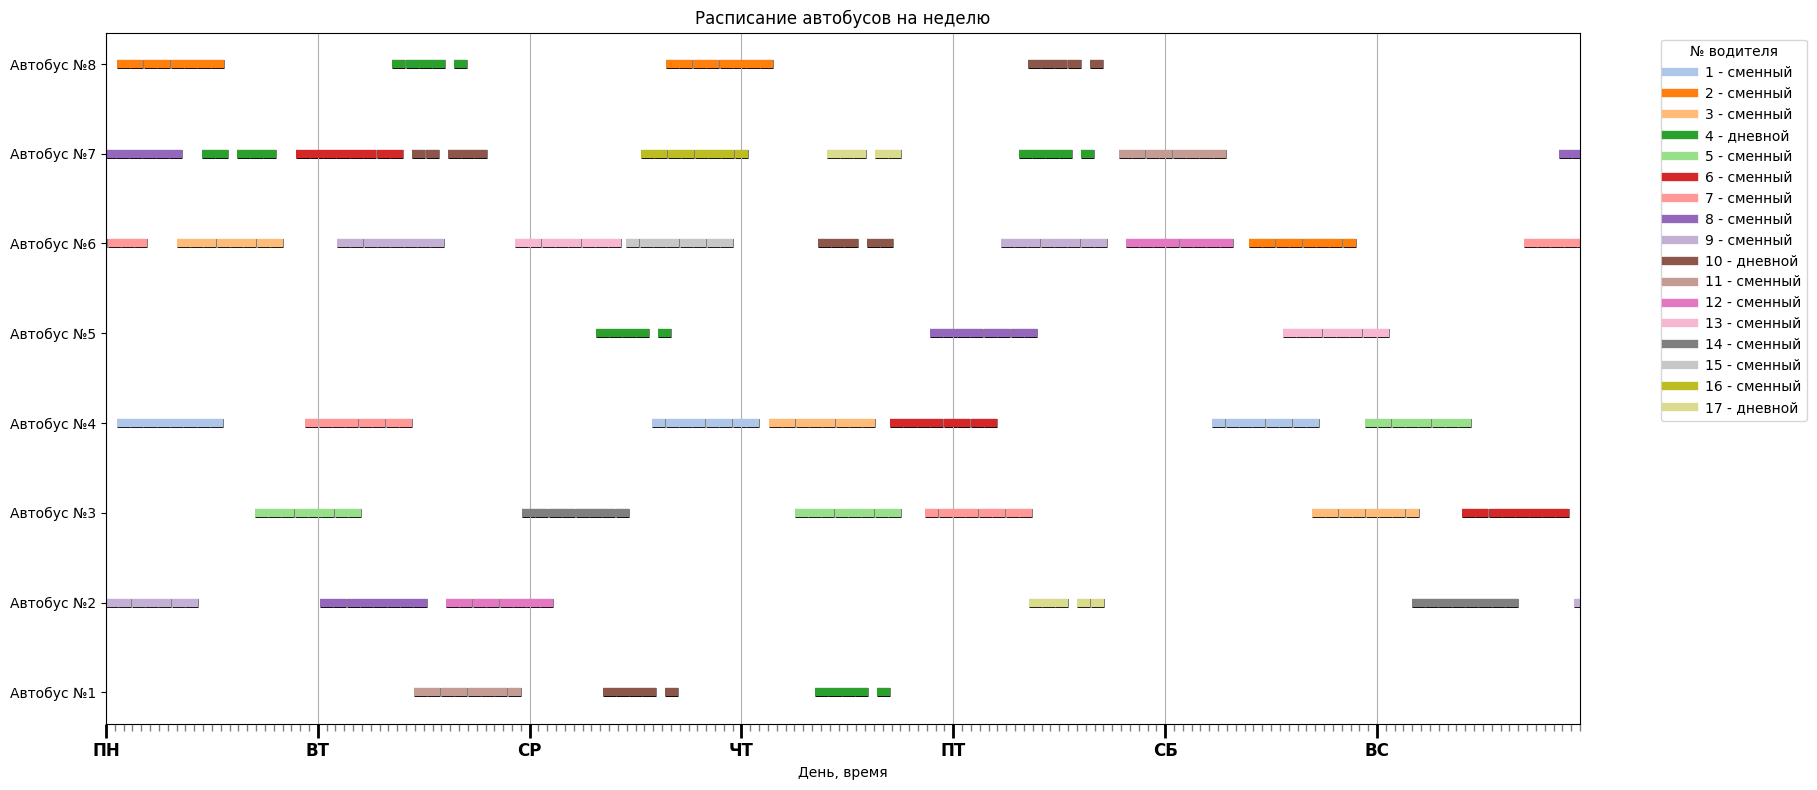

In [10]:
best_schedule = sorted(best_schedules,key=lambda x:(-x.score, x.drivers))[0]
display_multiple_interval_trees_and_get_drivers(best_schedule)

In [12]:
def first_null(i):
    if i<10:
        return "0"+str(i)
    else: return i

def display_drivers(drivers:list[Driver]):
    days = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
    rows = []
    for idx, dr in enumerate(drivers):
        row = {"№": f"Водитель {idx + 1}"}
        if dr.dr_type:
            row["Тип"] = "Дневной"
        else:
            row["Тип"] = "Сменный"
        for start, end in dr.dr_schedule:
            day = days[start//1440] 
            if day not in row:
                row[day] = []
            row[day].append((start, end))
        for day in row:
            if isinstance(row[day], list):
                row[day] = ", ".join([f"{first_null((s%1440)//60)}:{first_null(s%60)}-{first_null((e%1440)//60)}:{first_null(e%60)}" for s, e in row[day]])
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df[['№', 'Тип', "Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]]
    df = df.fillna("")
    return df

In [13]:
display_drivers(best_schedule.driver_list)

,№,Тип,Понедельник,Вторник,Среда,Четверг,Пятница,Суббота,Воскресенье
0,Водитель 1,Сменный,01:13-13:42,,13:54-02:23,,,05:21-17:50,
1,Водитель 2,Сменный,01:16-13:45,,15:28-03:57,,,09:30-21:59,
2,Водитель 3,Сменный,08:00-20:29,,,03:06-15:35,,16:38-05:07,
3,Водитель 4,Дневной,10:50-19:19,08:27-16:56,07:31-16:00,08:21-16:50,07:26-15:55,,
4,Водитель 5,Сменный,16:50-05:19,,,06:01-18:30,,22:37-11:06,
5,Водитель 6,Сменный,21:35-10:04,,,16:51-05:20,,,09:37-22:06
6,Водитель 7,Сменный,22:35-11:04,,,20:50-09:19,,,16:37-05:06
7,Водитель 8,Сменный,,00:14-12:43,,21:23-09:52,,,20:34-09:03
8,Водитель 9,Сменный,,02:10-14:39,,,05:21-17:50,,22:22-10:51
9,Водитель 10,Дневной,,10:43-19:12,08:17-16:46,08:40-17:09,08:27-16:56,,
